In [ ]:
! pip install medmnist

In [8]:
import medmnist
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import matplotlib.pyplot as plt

First of all, we need to load the data and preprocess it. BloodMNIST has already three splits: train, val, test. Also, we will use the ImageNet statistics for normalization.

In [4]:
data_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # from ImageNet
])

train_dataset = medmnist.BloodMNIST(split='train', transform=data_transform, download=True)
test_dataset = medmnist.BloodMNIST(split='test', transform=data_transform, download=True)
val_dataset = medmnist.BloodMNIST(split='val', transform=data_transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

100%|██████████| 35.5M/35.5M [00:03<00:00, 10.1MB/s]


In [ ]:
print(f'Train dataset size: {len(train_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')

images, labels = next(iter(train_loader))
print(f'Batch shape: {images.shape}')
print(f'Labels shape: {labels.shape}')

Train dataset size: 11959
Test dataset size: 3421
Validation dataset size: 1712
Batch shape: torch.Size([32, 3, 32, 32])
Labels shape: torch.Size([32, 1])


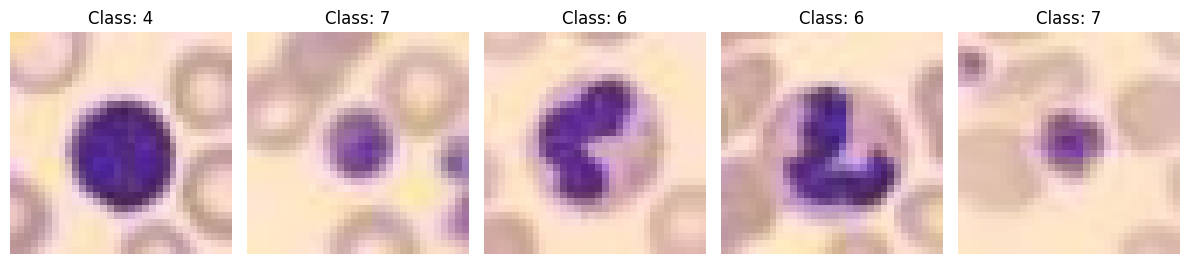

In [ ]:
def denormalize_image(image):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return image * std + mean

plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    img = denormalize_image(images[i])
    img = img.permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.title(f'Class: {labels[i].item()}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Baseline Model

In [ ]:
def train(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct = 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.squeeze().to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.squeeze().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)


Let's load the pre-trained ResNet-18 model and replace the final fully connected layer with a new one for our task. BloodMNIST has 8 classes, so we need to change the last layer to have 8 output neurons.

In [ ]:
def get_resnet18(num_classes=8):
    model = models.resnet18(pretrained=True)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()  # Remove aggressive downsampling
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

Let's define the loss function and optimizer. We will use the Adam optimizer with a learning rate of 0.001, since it has a good balance between convergence speed and stability. For the loss function, we will use the cross-entropy loss, since it is a good loss function for classification tasks.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 8

model = get_resnet18(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
train_optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
epochs = 20
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, criterion, train_optimizer, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}: Train acc: {train_acc:.4f}, Val acc: {val_acc:.4f}")

Epoch 1: Train acc: 0.8986, Val acc: 0.9229
Epoch 2: Train acc: 0.9187, Val acc: 0.9334
Epoch 3: Train acc: 0.9319, Val acc: 0.9287
Epoch 4: Train acc: 0.9424, Val acc: 0.9387
Epoch 5: Train acc: 0.9523, Val acc: 0.9322
Epoch 6: Train acc: 0.9568, Val acc: 0.9317
Epoch 7: Train acc: 0.9647, Val acc: 0.9410
Epoch 8: Train acc: 0.9715, Val acc: 0.9357
Epoch 9: Train acc: 0.9745, Val acc: 0.9322
Epoch 10: Train acc: 0.9788, Val acc: 0.9463
Epoch 11: Train acc: 0.9747, Val acc: 0.9509
Epoch 12: Train acc: 0.9833, Val acc: 0.9521
Epoch 13: Train acc: 0.9814, Val acc: 0.9509
Epoch 14: Train acc: 0.9849, Val acc: 0.9322
Epoch 15: Train acc: 0.9832, Val acc: 0.9439
Epoch 16: Train acc: 0.9880, Val acc: 0.9480
Epoch 17: Train acc: 0.9891, Val acc: 0.9539
Epoch 18: Train acc: 0.9883, Val acc: 0.9410
Epoch 19: Train acc: 0.9951, Val acc: 0.9492
Epoch 20: Train acc: 0.9887, Val acc: 0.9428


In [ ]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Accuracy: {test_acc:.4f}")

Test Accuracy: 0.9298


Now, lets also compute AUC.

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
import numpy as np

def compute_auc_score_safe(y_probs, y_true, all_classes):
    present_classes = np.unique(y_true)

    if len(present_classes) < 2:
        print("Not enough classes in test labels to compute AUC.")
        return np.nan

    y_true_bin = label_binarize(y_true, classes=all_classes)
    probs_filtered = y_probs[:, present_classes]

    try:
        auc = roc_auc_score(y_true_bin[:, present_classes], probs_filtered, average='macro', multi_class='ovr')
        return auc
    except Exception as e:
        print(f"Error computing AUC: {e}")
        return np.nan

def get_predictions_and_labels(model, loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.squeeze().cpu().numpy())

    return np.array(all_probs), np.array(all_labels)

In [ ]:
y_probs, y_true = get_predictions_and_labels(model, test_loader, device)
all_classes = list(range(num_classes))

auc_score = compute_auc_score_safe(y_probs, y_true, all_classes)
print(f"Test AUC: {auc_score:.4f}")


Test AUC: 0.9955


### Target Model

In [ ]:
! pip install transformers datasets evaluate

In [56]:
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer
from tqdm import tqdm
from datasets import load_dataset
from evaluate import load
import torch
import numpy as np

Lets load the data using hugging face load_dataset function for better compatability.

In [63]:
bloodMNIST_dataset = load_dataset("albertvillanova/medmnist-v2", "bloodmnist")

Lets use pretrained Google vit-base-patch16-224 model architecture. Then lets train it on our BloodMNIST dataset using the idea from here https://huggingface.co/blog/fine-tune-vit 

In [64]:
model_name = "google/vit-base-patch16-224"

processor = ViTImageProcessor.from_pretrained(model_name)

In [65]:
def transform(i):
  inputs = processor([img.convert("RGB") for img in i["image"]], return_tensors="pt")
  inputs["labels"] = i["label"]
  return inputs

bloodMNIST_loader = bloodMNIST_dataset.with_transform(transform)

In [66]:
metric = load("accuracy")
def compute_metrics(p):
    return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

In [68]:
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(bloodMNIST_loader["train"].features["label"].names),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)},
    ignore_mismatched_sizes=True,
)

training_args = TrainingArguments(
  output_dir="./output",
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=10,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=100,
  learning_rate=2e-4,
  save_total_limit=5,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=bloodMNIST_loader["train"],
    eval_dataset=bloodMNIST_loader["validation"],
    tokenizer=processor,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([8]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([8, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-68-d5dd4d85b569>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Now, lets train the model.

In [69]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
100,0.586200,0.335956,0.894276
200,0.278100,0.319939,0.887266
300,0.240400,0.148517,0.946846
400,0.166100,0.141100,0.951519
500,0.153400,0.228006,0.925818
600,0.193300,0.116890,0.957944
700,0.129700,0.163514,0.945678
800,0.094100,0.207862,0.935748
900,0.094400,0.105193,0.966706
1000,0.094000,0.184383,0.935748


TrainOutput(global_step=3740, training_loss=0.0664057518572193, metrics={'train_runtime': 1824.5656, 'train_samples_per_second': 65.544, 'train_steps_per_second': 2.05, 'total_flos': 9.267765395508265e+18, 'train_loss': 0.0664057518572193, 'epoch': 10.0})